In [121]:
import random
import re
import time

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta

from tqdm.notebook import tqdm
from IPython.display import clear_output
from collections import deque
from queue import PriorityQueue


plt.style.use('ggplot')
sns.set(font_scale=1.5)
tqdm.pandas()

# Simulator and Strategy

In [3]:
from dataclasses import dataclass
from typing import Optional


@dataclass
class Order:  # Our own placed order
    order_id: int
    side: str
    size: float
    price: float
    timestamp: float
        
@dataclass
class CancelOrder:  # Our own cancel order
    order_id: int
    timestamp: float

        
@dataclass
class AnonTrade:  # Market trade
    exchange_ts: float
    receive_ts: float
    side: str
    size: float
    price: str

        
@dataclass(order=True)
class OwnTrade:  # Execution of own placed order
    exchange_ts: float
    receive_ts: float
    receive_ts: float
    trade_id: int
    order_id: int
    side: str
    size: float
    price: float

        
@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    exchange_ts: float
    receive_ts: float
    asks: list[tuple[float, float]]  # tuple[price, size]
    bids: list[tuple[float, float]]

        
@dataclass
class MdUpdate:  # Data of a tick
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trade: Optional[AnonTrade] = None

In [120]:
class Strategy:
    def __init__(self, max_position: float, maker_fee: float = 0, time_to_cancel=0, trade_size=0.01) -> None:
        self.coin_position = 0
        self.money_position = 0
        self.max_position = max_position
        self.maker_fee = maker_fee
        self.trade_size = trade_size   # fixed trade size
        self.time_to_cancel = timedelta(milliseconds=time_to_cancel)   # waiting time before order cancellation
        
        self.best_bid = None
        self.best_ask = None
        self.current_time = pd.Timestamp(1655942402249000000)
        self.history = {'time': [], 'coin_position': [], 'money_position': [], 'mid_price': []}
        self.active_orders = []
        self.completed_trades = []
        self.prev_visualize_time = pd.Timestamp(1655942402249000000) # the first timestamp in md
        
    
    def visualize_pnl(self):
        timestamps, pnls = zip(*self.pnl)
        
        plt.figure(figsize=(15, 5))
        sns.lineplot(x=timestamps, y=pnls)
        plt.gca().xaxis.set_major_locator(mdates.HourLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        for label in plt.gca().get_xticklabels(which='major'):
            label.set(rotation=30, horizontalalignment='right')
        plt.title('PnL')
        plt.xlabel('Time')
        plt.ylabel('USDT')
        
        plt.show()
        
    def update_prices(self, md: MdUpdate) -> None:
        if md.orderbook:
            self.best_ask = md.orderbook.asks[0][0]
            self.best_bid = md.orderbook.bids[0][0]
            self.current_time = md.orderbook.receive_ts
        else:
            side = md.trade.side
            price = md.trade.price
            if side == 'BID':
                self.best_ask = price
            else:
                self.best_bid = price
            self.current_time = md.trade.receive_ts

    def run(self, sim: "Sim"):
        while True:
            try:
                _, sim_update = sim.tick()
                if isinstance(sim_update, OwnTrade):
                    self.completed_trades.append(sim_update)
                    for order in self.active_orders:
                        if order.order_id == sim_update.order_id:
                            self.active_orders.remove(order)
                    
                    if sim_update.side == 'ASK':
                        self.coin_position -= sim_update.size
                        self.money_position += sim_update.size * sim_update.price
                    else:
                        self.coin_position += sim_update.size
                        self.money_position -= sim_update.size * sim_update.price
                    
                    mid_price = (self.best_bid + self.best_ask) / 2
                    self.history['time'].append(self.current_time)
                    self.history['coin_position'].append(self.coin_position) 
                    self.history['money_position'].append(self.money_position) 
                    self.history['mid_price'].append(mid_price) 

                elif isinstance(sim_update, MdUpdate):
                    self.update_prices(sim_update)

                    for order in self.active_orders:
                        if self.current_time - order.timestamp >= self.time_to_cancel:
                            sim.cancel_order(order.order_id)
                            self.active_orders.remove(order)

                    if abs(self.coin_position) >= self.max_position and self.coin_position > 0:
                        side = 'ASK'
                    elif abs(self.coin_position) >= self.max_position and self.coin_position < 0:
                        side = 'BID'    
                    else:
                        side = random.choice(['BID', 'ASK'])

                    price = self.best_ask if side == 'ASK' else self.best_bid
                    new_order = sim.place_order(side, self.trade_size, price)
                    self.active_orders.append(new_order)


                    if self.current_time - self.prev_visualize_time > timedelta(minutes=5):
                        clear_output(True)
                        print(f'Current time: {self.current_time}')
                        print(f'Coin Position: {self.coin_position}')
                        print(f'Money Position: {self.money_position}')
    #                     self.visualize_pnl()
                        self.prev_visualize_time = self.current_time
                
            except (StopIteration, IndexError):
                break
                
        return self.history, self.completed_trades


def load_data(path: str) -> tuple[pd.DataFrame]:
    lobs_df = pd.read_csv(path + '/lobs.csv')
    trades_df = pd.read_csv(path + '/trades.csv')
    
    lobs_df.rename(columns=lambda x: re.sub('.*LinearPerpetual_', '', x).strip(), inplace=True)
    
    for column in ['receive_ts', 'exchange_ts']:
        lobs_df[column] = pd.to_datetime(lobs_df[column])
        trades_df[column] = pd.to_datetime(trades_df[column])
    
    return lobs_df, trades_df


def get_marketdata(row, lobs: bool):
    if lobs:  
        orderbook = OrderbookSnapshotUpdate(
            exchange_ts=row['exchange_ts'],
            receive_ts=row['receive_ts'],
            asks=row['asks'],
            bids=row['bids']
        )
        
        return MdUpdate(orderbook, None)
    else:
        trade = AnonTrade(
            exchange_ts=row['exchange_ts'],
            receive_ts=row['receive_ts'],
            side=row['aggro_side'],
            size=row['size'],
            price=row['price']
        )

        return MdUpdate(None, trade)

                
def load_md_from_file(path: str) -> list[MdUpdate]:
    lobs_df, trades_df = load_data(path)
    print('Data loaded successfully')
    
    prices_and_volumes = ['ask_price', 'ask_vol', 'bid_price', 'bid_vol']
    for filt in prices_and_volumes:
        lobs_df[filt] = lobs_df.filter(regex=filt).values.tolist()
    
    tqdm.pandas(desc="Lobs asks aggregating")
    lobs_df['asks'] = lobs_df[['ask_price', 'ask_vol']].progress_apply(lambda x: list(zip(x[0], x[1])), axis=1)
    tqdm.pandas(desc="Lobs bids aggregating")
    lobs_df['bids'] = lobs_df[['bid_price', 'bid_vol']].progress_apply(lambda x: list(zip(x[0], x[1])), axis=1)
    
    tqdm.pandas(desc="Lobs market data generating")
    md_lobs = lobs_df.progress_apply(get_marketdata,axis=1, lobs=True).values.tolist()
    tqdm.pandas(desc="Trades market data generating")
    md_trades = trades_df.progress_apply(get_marketdata, axis=1, lobs=False).values.tolist()
    md_queue = md_lobs + md_trades
    print('Sorting')
    md_queue = sorted(
        md_queue, key=lambda md_update: md_update.orderbook.receive_ts
        if md_update.orderbook else md_update.trade.receive_ts
    )

     
    return md_queue

In [14]:
class Sim:
    def __init__(self, path: str, execution_latency: float, md_latency: float, ready_md = None) -> None:
        self.execution_latency = timedelta(milliseconds=execution_latency) 
        self.md_latency = timedelta(milliseconds=md_latency)
        self.md_queue = deque(ready_md) if ready_md else deque(load_md_from_file(path))
        self.actions_queue = deque()
        self.strategy_updates_queue = PriorityQueue()
        self.strategy_updates_queue.put((self.get_event_time('md'), self.md_queue[0]))
        self.best_bid = 0
        self.best_ask = 0
        
        self.current_time = self.strategy_updates_queue.queue[0][0]
        self.active_orders = []
        self.order_id = 1
        self.trade_id = 1
        
    def get_event_time(self, style):
        if style == 'md' and self.md_queue:
            event_time = (
                self.md_queue[0].orderbook.exchange_ts if self.md_queue[0].orderbook else
                self.md_queue[0].trade.exchange_ts
            )
        elif style == 'strategy' and not self.strategy_updates_queue.empty():
            event_time, _ = self.strategy_updates_queue.queue[0]
            
        elif style == 'actions' and self.actions_queue:
            event_time = self.actions_queue[0].timestamp
        else:
            event_time = pd.Timestamp.max
        
        return event_time
    
    def apply_md_update(self, md: MdUpdate):
        if md.orderbook:
            self.best_ask = md.orderbook.asks[0][0]
            self.best_bid = md.orderbook.bids[0][0]
            receive_ts = md.orderbook.receive_ts
        else:
            side = md.trade.side
            price = md.trade.price
            if side == 'BID':
                self.best_ask = price
            else:
                self.best_bid = price
            receive_ts = md.trade.receive_ts
            
        self.strategy_updates_queue.put((receive_ts,md))

    def tick(self):
        strategy_time = self.get_event_time('strategy')
        md_time = self.get_event_time('md')
        actions_time = self.get_event_time('actions')
        
        while md_time <= strategy_time or actions_time <= strategy_time:
            if md_time < actions_time:
                self.apply_md_update(self.md_queue.popleft())
                self.execute_orders()
                
                self.current_time = md_time
                md_time = self.get_event_time('md')
                strategy_time = self.get_event_time('strategy')
            else:
                self.prepare_orders(self.actions_queue.popleft())
                self.execute_orders()
                
                self.current_time = actions_time
                actions_time = self.get_event_time('actions')
                strategy_time = self.get_event_time('strategy')
        
        return self.strategy_updates_queue.get_nowait()
    
    def check_order(self, order: Order) -> bool:
        if order.side == 'BID' and order.price >= self.best_ask:
            return 1
        
        if order.side == 'ASK' and order.price <= self.best_bid:
            return 1

        return 0

    def prepare_orders(self, action_order) -> None:
        if isinstance(action_order, Order):
            self.active_orders.append(action_order)
        else:
            for order in self.active_orders:
                if order.order_id == action_order.order_id:
                    self.active_orders.remove(order)
                    

    def execute_orders(self) -> list[Order]:
        for order in self.active_orders:
            if self.check_order(order):
                self.strategy_updates_queue.put(
                    (self.current_time + self.md_latency,
                     OwnTrade(
                        exchange_ts=self.current_time,
                        receive_ts=self.current_time + self.md_latency,
                        trade_id=self.trade_id,
                        order_id=order.order_id,
                        side=order.side,
                        size=order.size,
                        price=order.price
                     )
                    )
                )
                    
                self.trade_id += 1
                self.active_orders.remove(order)
            
        return self.active_orders

    def place_order(self, side: str, size: float, price: float) -> Order:
        new_order = Order(
            order_id=self.order_id,
            side=side,
            size=size,
            price=price,
            timestamp=self.current_time + self.execution_latency
        )
        self.actions_queue.append(new_order)
        self.order_id += 1
        return new_order
        
    def cancel_order(self, order_id: int) -> None:
        new_cancel_order = CancelOrder(
            order_id=order_id,
            timestamp=self.current_time + self.execution_latency
        )
        self.actions_queue.append(new_cancel_order)

# Strategy running

In [5]:
# %%time
# ready_md = load_md_from_file("md/btcusdt:Binance:LinearPerpetual")

In [15]:
%%time

# with open('data/market_data.pickle', 'rb') as f:
#     ready_md = pickle.load(f)
    
sim = Sim("md/btcusdt:Binance:LinearPerpetual", 3, 3, ready_md=ready_md)
strategy = Strategy(max_position=1, maker_fee=0, time_to_cancel=50, trade_size=0.001)

CPU times: user 198 ms, sys: 2.29 s, total: 2.49 s
Wall time: 3.67 s


In [16]:
%%time

history, completed_trades = strategy.run(sim)

Current time: 2022-06-23 23:55:07.548751316
Coin Position: -1.0040000000000002
Money Position: 18905.38010999907
CPU times: user 16min 6s, sys: 15.5 s, total: 16min 22s
Wall time: 16min 32s


# Results Vizualization

In [54]:
def get_pnl(history):
    df = pd.DataFrame({
        'time': history['time'],
        'coin_position': history['coin_position'],
        'money_position': history['money_position'],
        'mid_price': history['mid_price'],    
    })
    df['pnl'] = df.money_position + df.coin_position * df.mid_price
    return df

In [103]:
def visualize_pnl_(df, save_path=None):

    fig, _ = plt.subplots(1, 1, figsize=(15, 5))
    sns.lineplot(x=df.index.values[::50], y=df.pnl.values[::50])
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    for label in plt.gca().get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    plt.title('PnL')
    plt.xlabel('Time')
    plt.ylabel('USDT')

    plt.show()
    if save_path:
        fig.savefig(save_path)

In [112]:
df = get_pnl(history)

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# pnl = df.groupby('time')['pnl'].last()

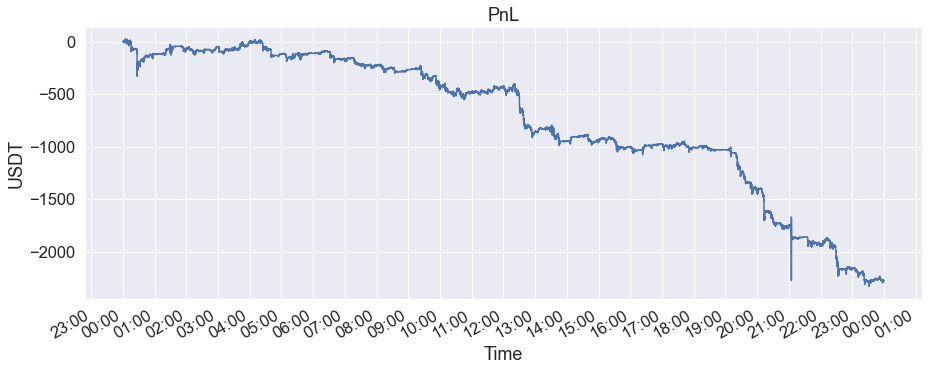

In [113]:
visualize_pnl_(df)

In [115]:
# with open('data/pnl.pickle', 'rb') as f:
#     pnl = pickle.load(f)

In [108]:
# df.iloc[1400830:1400839, :]

,coin_position,money_position,mid_price,pnl
time,,,,
2022-06-23 21:04:54.163320471,0.999,-22563.9221,20773.975,-1810.721075
2022-06-23 21:04:54.163320471,1.000,-22584.7077,20773.975,-1810.732700
2022-06-23 21:04:54.166241133,1.001,-22605.4933,20785.650,-1799.057650
2022-06-23 21:04:54.198302508,1.002,-22626.2789,20785.650,-1799.057600
2022-06-23 21:04:54.203729877,1.001,-22626.2789,10392.800,-12223.086100
2022-06-23 21:04:54.203729877,1.000,-22605.4932,10392.800,-12212.693200
2022-06-23 21:04:54.215291094,0.999,-22584.7075,10392.850,-12202.250350
2022-06-23 21:04:54.215291094,0.998,-22584.7075,10392.850,-12212.643200
2022-06-23 21:04:54.218135298,0.997,-22584.7075,20785.800,-1861.264900
